In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Step 1. Measure the Determinants of Confidence Including Crime Outcomes

In [39]:
outcome_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/outcome.csv')

print(outcome_df['Outcome type'].unique())

['Investigation complete; no suspect identified' 'Local resolution'
 'Suspect charged' 'Offender given penalty notice'
 'Offender given a caution' 'Offender given a drugs possession warning'
 'Suspect charged as part of another case'
 'Formal action is not in the public interest'
 'Unable to prosecute suspect']


In [60]:
def categorize_outcome(outcome):
    successful_outcomes = [
        'Suspect charged', 
        'Offender given penalty notice',
        'Offender given a caution', 
        'Offender given a drugs possession warning',
        'Suspect charged as part of another case'
    ]
    unsuccessful_outcomes = [
        'Investigation complete; no suspect identified', 
        'Formal action is not in the public interest',
        'Unable to prosecute suspect'
    ]
    
    if outcome in successful_outcomes:
        return "Successful"
    elif outcome in unsuccessful_outcomes:
        return "Unsuccessful"
    else:
        return "Other"

outcome_df['Intervention_Success'] = outcome_df['Outcome type'].apply(categorize_outcome)

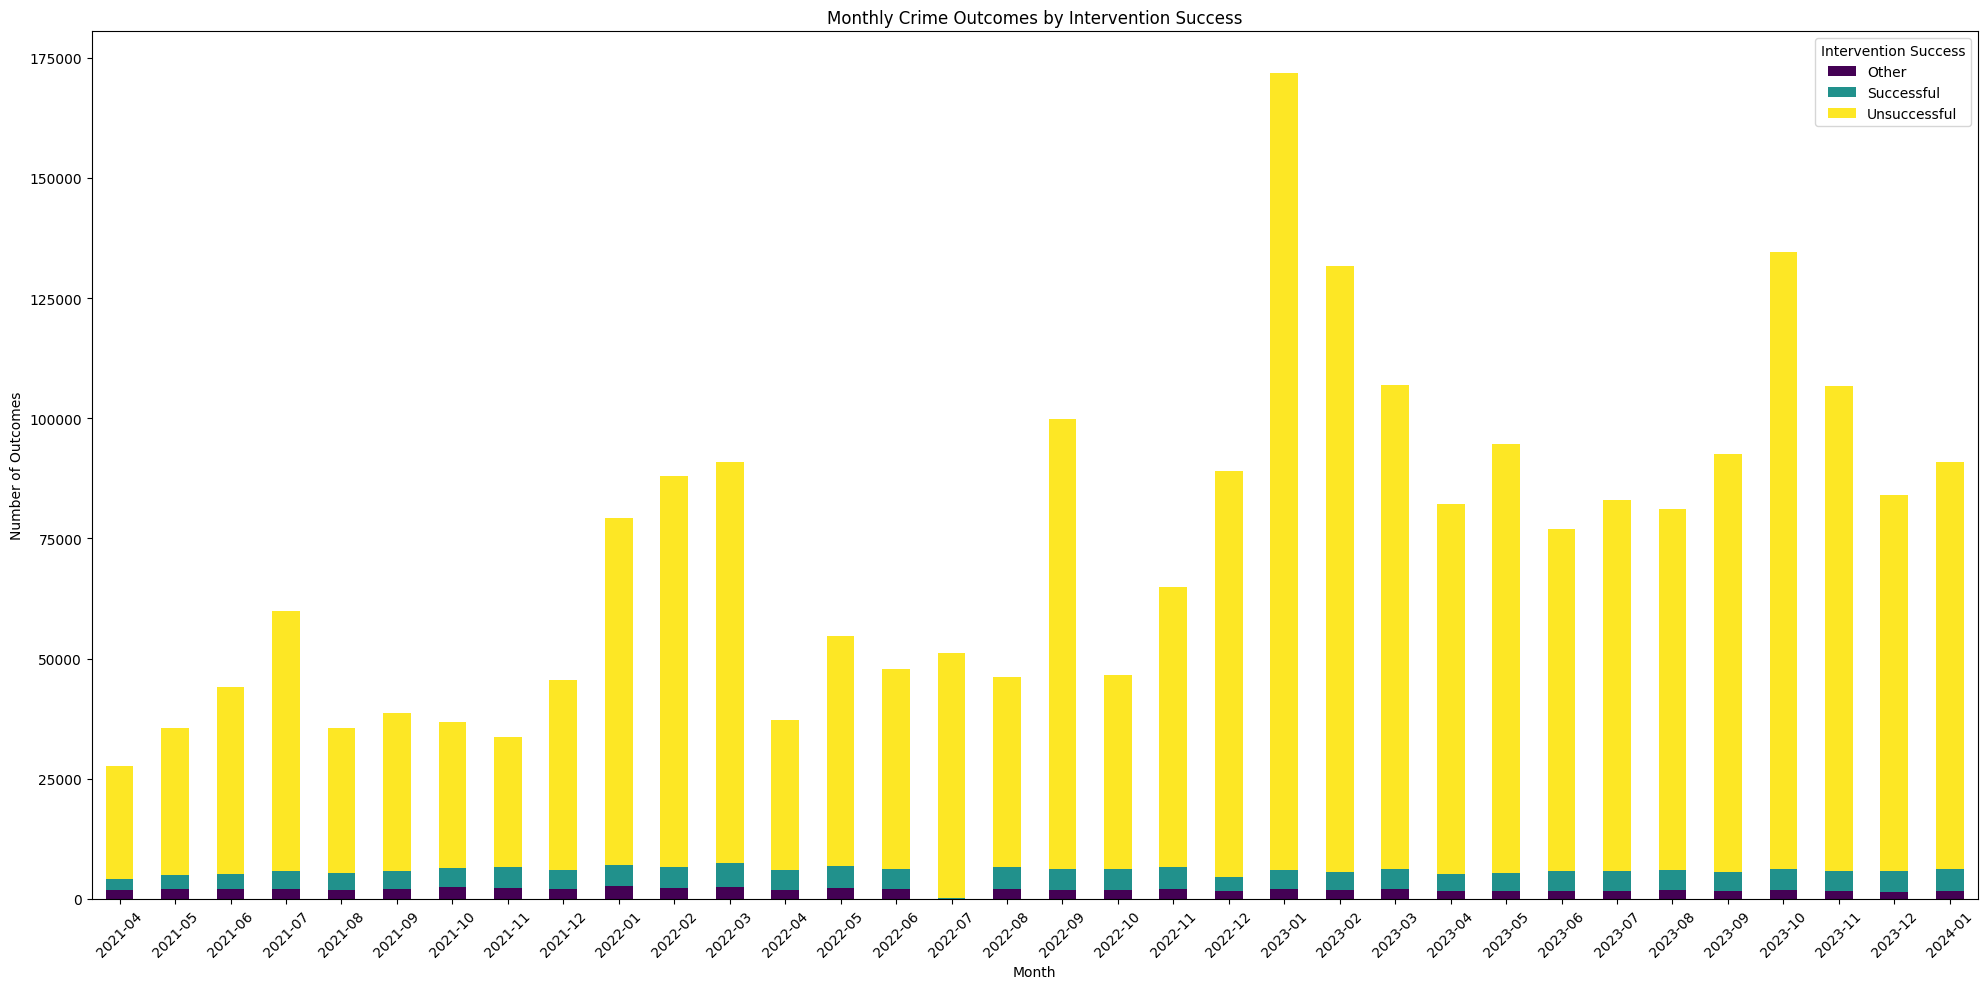

In [61]:
monthly_outcomes = outcome_df.groupby(['Month', 'Intervention_Success']).size().unstack(fill_value=0)

monthly_outcomes.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')
plt.title('Monthly Crime Outcomes by Intervention Success')
plt.xlabel('Month')
plt.ylabel('Number of Outcomes')
plt.xticks(rotation=45)
plt.legend(title='Intervention Success')
plt.tight_layout()
plt.show()

Step 2. Data Preparation

In [95]:
# Mapping function

label_to_value_map = {
    '1 Not at all well': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 Very well': 7,
    "Don't know": 97,
    'Refused': 98,
    'Not Asked': 99,

    'Strongly agree': 5,
    'Tend to agree': 4,
    'Neither agree nor disagree': 3,
    'Tend to disagree': 2,
    'Strongly disagree': 1,
    

    'Yes': 2,
    'No': 1,

    'Very confident': 4,
    'Fairly confident': 3,
    'Not very confident': 2,
    'Not at all confident': 1,

    'At least daily': 6,
    'At least weekly': 5,
    'At least fortnightly': 4,
    'At least monthly': 3,
    'Less often': 2,
    'Never': 1,

    'Very safe': 6,
    'Fairly safe': 5,
    'Fairly unsafe': 4,
    'Very unsafe': 2,
    '(spontaneous) Do not go out at all': 1,
    '(spontaneous) Do not go out alone': 3,

    'Very well informed': 3,
    'Fairly well informed': 2,
    'Not at all informed': 1
}

def label_to_value(label):
    return label_to_value_map.get(label, label)  # Return the label itself if not found in the map


In [96]:
files = [
    "data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv"
]

all_data = pd.DataFrame()

survey_columns = [
    'MONTH', 'C2',
    'Q79I', 'Q79B', 'Q79D', 'Q79E',  # Effectiveness
    'Q62B', 'Q62C', 'A121',  # Fairness and engagement
    'NQ135BH',  # Accountability
    'Q65', 'Q21', 'Q131'  # Confidence
]


dataframes = []
for file in files:
    try:

        df = pd.read_csv(file)
        
        cols_to_select = [col for col in survey_columns if col in df.columns]
        selected_df = df[cols_to_select]
        
        dataframes.append(selected_df)
        print(f"Loaded {file} with selected columns.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all the dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\156777640.py:25: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,35,177,410,411,412,415,416,417,418,419,420,421,422,423) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\156777640.py:25: DtypeWarning: Columns (30,31,32,98,99,100,101,102,103,104,105,125,126,127,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\156777640.py:25: DtypeWarning: Columns (25,26,27,28,108,109,110,112,113,137,202,203,381) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\156777640.py:25: DtypeWarning: Columns (41,42,43,131,132,133,213,214,435,444,451) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [97]:
# Do the mapping
for column in combined_df.columns:
    combined_df[column] = combined_df[column].apply(label_to_value)

In [98]:
def scale_0_1(value, min_val, max_val):
    if value in [97, 98, 99]:  # Did't consider 'Don't know', 'Refused', 'Not Asked' WE MUST INTERFERE HERE
        return None
    if pd.isna(value):
        return None
    return (value - min_val) / (max_val - min_val)

max_values = {
    'Q79I': 7, 'Q79B': 7, 'Q79D': 5, 'Q79E': 5,
    'Q62B': 5, 'Q62C': 5, 'A121': 4,
    'NQ135BH': 5,
    'Q65': 6, 'Q21': 6, 'Q131': 3
}

for column in max_values:
    if column in combined_df.columns:
        combined_df[column] = combined_df[column].apply(lambda x: scale_0_1(x, 1, max_values[column]))

In [99]:
grouped = combined_df.groupby(['MONTH', 'C2']).median().reset_index()

effectiveness_questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E']
fairness_engagement_questions = ['Q62B', 'Q62C', 'A121']
accountability_questions = ['NQ135BH']
confidence_questions = ['Q65', 'Q21', 'Q131']

# MAKE SURE MEAN IS CORRECT
grouped['Effectiveness'] = grouped[effectiveness_questions].mean(axis=1)
grouped['Fairness and Engagement'] = grouped[fairness_engagement_questions].mean(axis=1)
grouped['Accountability'] = grouped[accountability_questions].mean(axis=1)
grouped['Confidence Questions'] = grouped[confidence_questions].mean(axis=1)

# Calculate 'Trust' as the mean of the first three categories
grouped['Trust'] = grouped[['Effectiveness', 'Fairness and Engagement', 'Accountability']].mean(axis=1)

# Update 'Confidence' to be the mean of itself and 'Trust'
grouped['Confidence'] = grouped[['Confidence Questions', 'Trust']].mean(axis=1)

In [100]:
# Change the format of the month
grouped['Date'] = pd.to_datetime(grouped['MONTH'].str.extract(r'\((.*?)\)')[0], format='%b %Y')
grouped.sort_values('Date', inplace=True)
grouped['MONTH'] = grouped['Date'].dt.strftime('%b %Y')

Step 3. Preparation of final DataFrame

In [101]:
# MAKE SURE MEAN IS CORRECT
final_grouped = grouped.groupby(['MONTH', 'C2']).mean().reset_index()

In [102]:
final_grouped.head()

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,Q65,Q21,Q131,Effectiveness,Fairness and Engagement,Accountability,Confidence Questions,Trust,Confidence,Date
0,Apr 2015,Barking and Dagenham,NaN,0.666667,1.0,1.0,0.750,0.75,0.666667,NaN,0.2,0.6,0.5,0.888889,0.722222,NaN,0.433333,0.805556,0.619444,2015-04-01
1,Apr 2015,Barnet,NaN,0.666667,1.0,1.0,0.875,0.75,0.666667,NaN,0.2,0.8,0.5,0.888889,0.763889,NaN,0.500000,0.826389,0.663194,2015-04-01
2,Apr 2015,Bexley,NaN,0.666667,1.0,1.0,0.750,0.75,0.666667,NaN,0.4,0.8,0.5,0.888889,0.722222,NaN,0.566667,0.805556,0.686111,2015-04-01
3,Apr 2015,Brent,NaN,0.666667,1.0,1.0,0.750,0.75,0.666667,NaN,0.5,0.8,0.0,0.888889,0.722222,NaN,0.433333,0.805556,0.619444,2015-04-01
4,Apr 2015,Bromley,NaN,0.666667,1.0,1.0,0.750,0.75,0.666667,NaN,0.6,0.8,0.5,0.888889,0.722222,NaN,0.633333,0.805556,0.719444,2015-04-01


In [117]:
# WHY IS THERE ONE THAT HAS HIGHER THAN 1 ????????????????????
max_trust_per_borough = final_grouped.groupby('C2')['Trust'].max()
print("Maximum Trust values per Borough:")
print(max_trust_per_borough)


Maximum Trust values per Borough:
C2
Barking and Dagenham      1.013889
Barnet                    0.944444
Bexley                    1.003472
Brent                     0.944444
Bromley                   0.958333
Camden                    0.916667
Croydon                   0.958333
Ealing                    0.907407
Enfield                   0.833333
Greenwich                 0.958333
Hackney                   0.942130
Hammersmith and Fulham    1.034722
Haringey                  0.916667
Harrow                    0.916667
Havering                  0.978009
Hillingdon                0.914352
Hounslow                  0.979167
Islington                 1.000000
Kensington and Chelsea    1.013889
Kingston upon Thames      0.872685
Lambeth                   0.916667
Lewisham                  0.979167
Merton                    0.930556
Newham                    1.013889
Redbridge                 0.975694
Richmond upon Thames      0.916667
Southwark                 0.972222
Sutton            

C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\2421026593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
C:\Users\20220678\AppData\Local\Temp\ipykernel_32596\2421026593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_data.sort_values('MONTH', inplace=True)


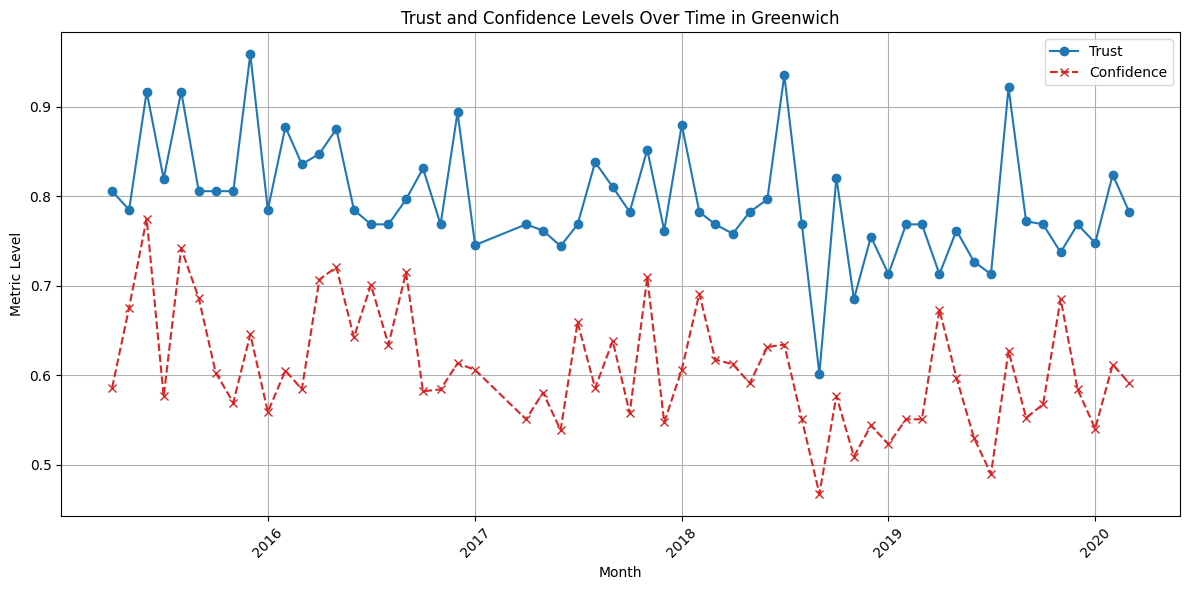

In [138]:
camden_data = final_grouped[final_grouped['C2'] == 'Greenwich']
camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
camden_data.sort_values('MONTH', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(camden_data['MONTH'], camden_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(camden_data['MONTH'], camden_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()